In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

We'll emulate a simple problem of learning to classify MNIST from states and actions.

In [2]:
from sklearn.datasets import load_digits
_x,_y = load_digits(return_X_y=True)

all_states = (_x/_x.max()).astype('float32')
action_rewards = np.zeros((len(_y),len(set(_y)))).astype('float32')
action_rewards[np.arange(len(_y)),_y]=1

state_size = all_states.shape[1]
n_actions = action_rewards.shape[1]

In [3]:
import theano, theano.tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import Normal,Constant

In [40]:

class Bandit:
    """a bandit with bayesian neural net"""
    def __init__(self,state_size=state_size,n_actions=n_actions):
        
        #input variables
        input_states = T.matrix("states")
        target_actions = T.ivector("actions taken")
        target_rewards = T.vector("rewards")
        
        batch_size = target_actions.shape[0]

        ###
        #network body
        inp = InputLayer((None,state_size),name='input')

        hid = DenseLayer(inp,50,
                         nonlinearity=T.nnet.elu,name='hidden')
        
        # mean
        mu = DenseLayer(hid, n_actions, nonlinearity=None)
        
        # variance
        rho = DenseLayer(hid, n_actions, nonlinearity=None)

        
        ###
        #prediction
        mu_all_actions,rho_all_actions = get_output([mu,rho],inputs=input_states)
        
        #compute variance as e^rho
        var_all_actions = T.exp(rho_all_actions)
        
        self.predict_mu_sigma = theano.function([input_states],[mu_all_actions,var_all_actions**.5])


        ###
        #Training

        #select prediction for taken actions
        mu_target_actions = mu_all_actions[T.arange(batch_size),target_actions]
        var_target_actions = var_all_actions[T.arange(batch_size),target_actions]
        rho_target_actions = rho_all_actions[T.arange(batch_size),target_actions]
        
        #compute log-likelihood
        #llh = <compute _mean_ logarithm of normal distribution given mu and var=sigma^2>
        #llh = - np.log(np.pi) - () ** 2 / 2 * sigma ** 2
        
        llh = - T.mean((mu_target_actions - target_rewards) ** 2 / (2 * var_target_actions)) - 0.5 * T.mean(T.log(var_target_actions))
        
        #loss = negative log-likelihood (mse) + regularizer
        reg = 0*var_target_actions.mean()
        loss = -llh + 1e-2*reg


        #gradient descent
        weights = get_all_params([mu, rho], trainable=True)
        updates = lasagne.updates.adam(loss, weights)
        
        self.train_step = theano.function([input_states,target_actions,target_rewards],
                                          [-llh.mean(),reg.mean()],updates = updates,
                                          allow_input_downcast=True)
    
    
    epsilon=0.2
    def get_action(self,states):
        """
        picks action based on e-greedy
        """
        assert states.ndim==2,"states must be 2-dimensional"
        
        #compute best actions. At first, try epsilon-greedy algorithm with epsilon=0.1
        #<your code here, use self.get_mu_sigma to compute all actions>
        mu, sigma = self.predict_mu_sigma(states)
        
        best_actions = mu.argmax(-1)
        rnd_actions = np.random.choice(n_actions, len(best_actions))
        mask = np.random.choice(2, len(best_actions), p=(self.epsilon, 1 - self.epsilon))
        
        chosen_actions = np.choose(mask, [rnd_actions, best_actions])
        
        return chosen_actions


### Train the bandit

We emulate infinite stream of data and pick actions using agent's get_action function.

In [41]:
def get_new_samples(states,action_rewards,batch_size=1):
    """samples random minibatch, emulating new users"""
    batch_ix = np.random.randint(0,len(states),batch_size)
    return states[batch_ix],action_rewards[batch_ix]

In [ ]:
bandit = Bandit()

iteration #350	mean reward=0.801	mse=-3.019	reg=0.000


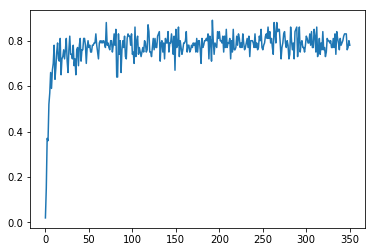

In [ ]:
from IPython.display import clear_output
batch_size = 100
rewards_history = []

for i in range(1000):
    ###
    #new data
    b_states,b_action_rewards = get_new_samples(all_states,action_rewards,batch_size)
    
    ###
    #pick actions
    b_actions = bandit.get_action(b_states)
    
    ###
    #rewards for actions agent just took
    b_rewards = b_action_rewards[np.arange(batch_size),b_actions]
    
    ###
    #train bandit
    for _ in range(100):
        mse,reg = bandit.train_step(b_states,b_actions,b_rewards)
    
    rewards_history.append(b_rewards.mean())
    
    if i%10 ==0:
        clear_output(True)
        print("iteration #%i\tmean reward=%.3f\tmse=%.3f\treg=%.3f"%(i,np.mean(rewards_history[-10:]),mse,reg))
        plt.plot(rewards_history)
        plt.show()

### Bayesian UCB

In [ ]:
class UCBBandit(Bandit):
    k=1
    def get_action(self,states):
        """
        picks action based on UCB exploration policy
        """
        assert states.ndim==2,"states must be 2-dimensional"
        
        #compute best actions. Try bayesian ucb (max of mu + k*sigma, start with k=1)
        <your code here, use self.get_mu_sigma to estimate best actions>
        
        return <best actions>


In [ ]:
bandit = UCBBandit()

In [ ]:
from IPython.display import clear_output
batch_size = 100
rewards_history = []

for i in range(1000):
    ###
    #new data
    b_states,b_action_rewards = get_new_samples(all_states,action_rewards,batch_size)
    
    ###
    #pick actions
    b_actions = bandit.get_action(b_states)
    
    ###
    #rewards for actions agent just took
    b_rewards = b_action_rewards[np.arange(batch_size),b_actions]
    
    ###
    #train bandit
    mse,reg = bandit.train_step(b_states,b_actions,b_rewards)
    
    rewards_history.append(b_rewards.mean())
    
    if i%10 ==0:
        clear_output(True)
        print("iteration #%i\tmean reward=%.3f\tmse=%.3f\treg=%.3f"%(i,np.mean(rewards_history[-10:]),mse,reg))
        plt.plot(rewards_history)
        plt.show()

### More will follow

We'll publish second part shortly...